<p style="text-align: center; font-size:20px">Case Stone Payments
<p style="text-align: center; font-size:15px">Customer Relationship Management (CRM) Analytics
<hr />

# Questions

In [1]:
import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
import pandasql

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# Loading df's and resetting Dtypes
df_factor = pd.read_csv("df_factor.csv")
df = pd.read_csv("df_cleaned.csv")

df[['cred_date', 'date_ref']] = df[['cred_date', 'date_ref']].apply(pd.to_datetime)
pesquisa_cat = df['pesquisa_sat'].unique().tolist()
df['pesquisa_sat'] = pd.Categorical(df['pesquisa_sat'], categories=pesquisa_cat, ordered=False)

#### 1. <b>A new feature was implemented on the 1st of August on the TON website that they believe will decrease the amount of incoming calls related to our product. Assess whether the implementation had a statistically significant impact.

Objective: Plot the number of calls in the week and check if there was a reduction after August 1 (week 2020-32)

*Assumption: the new functionality affects at least channel 2 (phone) - which are the only values we have in df*

In order to plot with better visibility of the X axis, it was preferable to replace dates by their respective weeks of the year:

In [3]:
# Eliminate day and capture week of year
df['y_w_cred'] = df['cred_date'].dt.strftime('%Y-%U')
df['y_w_ref'] = df['date_ref'].dt.strftime('%Y-%U')

Before, it is important to check the trend of Ton's customer base:

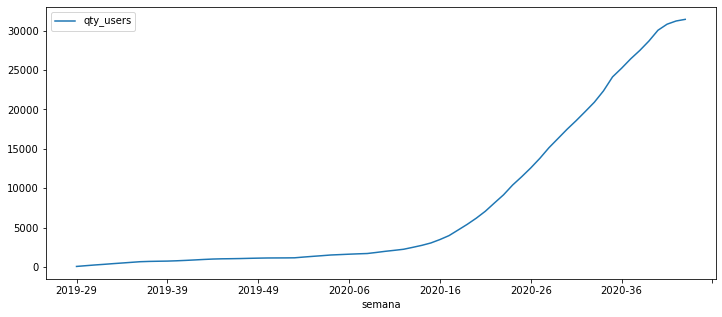

In [4]:
# Count (accumulative) of id's accreditations (distinct) per week
# To find out how many customers we have per week of the year (taking into account that none left).
sum_users = df.groupby('y_w_cred')['accountid'].agg(list).cumsum()
sum_users = sum_users.map(lambda x : len(set(x))).reset_index()
sum_users.rename(columns={'y_w_cred': 'semana', 'accountid': 'qty_users' }, inplace=True)

# Plotar resultado
sum_users.plot(x='semana', y='qty_users',kind='line',figsize=(12,5));

There was a vertiginous growth in the number of TON customers (assuming zero turnover). Therefore, it is suggested to analyze not only the number of calls (which naturally must have increased), but its **proportion with the total number of customers in the week of the year.**

In [5]:
# Count (non-cumulative) of id's (non-distinguished) calls per week
# To find out how many callings we have per week of the year.
sum_ref = df.groupby(['y_w_ref',], as_index=False).count()
sum_ref.rename(columns={'y_w_ref': 'semana', 'accountid': 'qty_refs' }, inplace=True)
sum_ref = sum_ref[['semana', 'qty_refs']]

# Join the df above (sum_ref) with the df from the previous cell (sum_users)
df_sum = sum_users.join(sum_ref.set_index('semana'), on='semana')
df_sum = df_sum.dropna(how='any',axis=0) # Remover linhas faltantes

# Feature 'refs_per_totalusers'
# Calculating the proportion of calls by the total qty of users
df_sum['refs_per_totalusers'] = ((df_sum['qty_refs'] / df_sum['qty_users'])*100)
df_sum


,semana,qty_users,qty_refs,refs_per_totalusers
32,2020-08,1700,91.0,5.352941
33,2020-09,1836,264.0,14.379085
34,2020-10,1982,190.0,9.586276
35,2020-11,2107,59.0,2.800190
36,2020-12,2240,81.0,3.616071
37,2020-13,2482,271.0,10.918614
38,2020-14,2735,329.0,12.029250
39,2020-15,3040,379.0,12.467105
40,2020-16,3474,424.0,12.204951
41,2020-17,3973,514.0,12.937327


*Note: As expected, qty_users increases over time, likely a reflection of the growth in the customer base*

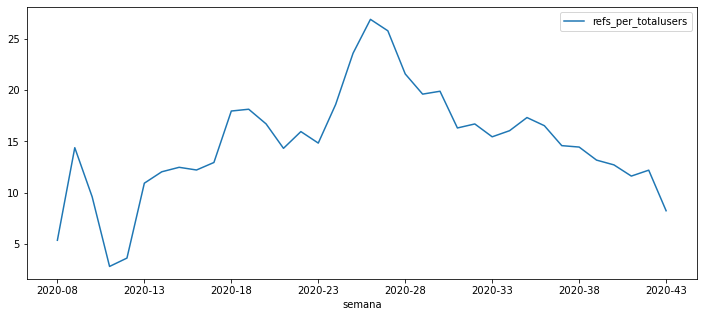

In [6]:
# Plot refs_per_totalusers
df_sum.plot(x='semana', y='refs_per_totalusers',kind='line', figsize=(12,5));

<b>August 1 2020 = week 32 <b>
    
There is indeed a drop in the number of calls per total number of customers in the week, but it has been following a downward trend since mid-June (week 26).

**To try to identify more accurately**, I will find the average of the daily percentage differences between 23 Jun (beginning of the fall - *Week 26*) to 31 Jul (1 day before the new feature - *Week 31*), and compare it with the average of the daily percentage differences between Aug 01 (new functionality - *Week 32*) to Sep 08 (same 39-day interval - *Week 37*)

Repeating previous commands, but not grouping dates by week, and creating *diff_perc* feature (the percentage difference in *refs_per_totalusers* from one day to the next):

In [7]:
# Count (accumulative) of (distinct) id accreditations per day
# To find out how many customers we have per day (taking into account that none left)
df_diff_cred = df.groupby('cred_date')['accountid'].agg(list).cumsum()
df_diff_cred = df_diff_cred.map(lambda x : len(set(x))).reset_index()
df_diff_cred.rename(columns={'cred_date':'date','accountid': 'qty_users'}, inplace=True)

# Count (non-cumulative) of id's (non-distinguished) calls per day
# To find out how many calls we have per day
df_diff_ref = df.groupby(['date_ref',], as_index=False).count()
df_diff_ref = df_diff_ref[['date_ref', 'accountid']] 
df_diff_ref.rename(columns={'date_ref':'date','accountid': 'qty_refs'}, inplace=True)

# Join dfs
df_diff = df_diff_cred.join(df_diff_ref.set_index('date'), on='date')
df_diff = df_diff.dropna(how='any',axis=0) # Remover linhas faltantes

# Feature 'refs_per_totalusers'
# Calculating the proportion of calls by the total qty of users
df_diff['refs_per_totalusers'] = ((df_diff['qty_refs'] / df_diff['qty_users'])*100)

# Feature 'diff_perc'
# Calculating the percentage difference in 'refs_per_totalusers' from one day to the next
df_diff['diff_perc'] = df_diff['refs_per_totalusers'].pct_change().fillna(0)
df_diff.head()

,date,qty_users,qty_refs,refs_per_totalusers,diff_perc
193,2020-02-26,1667,22.0,1.319736,0.000000
194,2020-02-27,1681,31.0,1.844140,0.397355
195,2020-02-28,1695,27.0,1.592920,-0.136226
196,2020-02-29,1700,9.0,0.529412,-0.667647
197,2020-03-01,1704,11.0,0.645540,0.219353


In [8]:
# Average of diff_perc values
# ~6 week range: 23 Jun (beginning of fall) - 31 Jul (1 day before new feature)
df_diff[df_diff['date'].between('2020-06-23','2020-07-31')]['diff_perc'].describe()

count    39.000000
mean      0.212066
std       1.005352
min      -0.567281
25%      -0.254928
50%      -0.081575
75%       0.053279
max       3.080716
Name: diff_perc, dtype: float64

In [9]:
# Average of diff_perc values
# ~6 week break: 01 Aug (new functionality) - 08 Sep (same break as before)
df_diff[df_diff['date'].between('2020-08-01','2020-09-08')]['diff_perc'].describe()

count    39.000000
mean      0.361474
std       1.344679
min      -0.629662
25%      -0.293687
50%      -0.059496
75%       0.063904
max       4.348040
Name: diff_perc, dtype: float64

There is a slow increase of 0.149408 between the average daily percentage differences in the period of fall before vs after the new functionality (Increase ~70%).

**Conclusion:** The new functionality did not result in a statistically significant impact.

#### 2. <b> It has been noticed by some RC agents that newer customers have a specific behavior regarding the number of calls made right after their accreditation. Prepare some way to visualize this difference noticed by agents.

I had already extracted the *housetime* feature - now plotting to explore patterns:

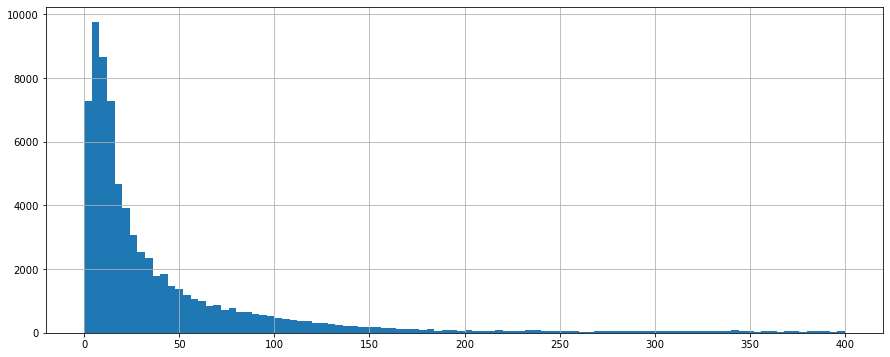

In [10]:
df['tempo_de_casa'].hist(figsize=(15,6), bins=100, rwidth=1, range=[0, 400]);

Clearly there is a tendency to open new cases much larger in the first 20 days, which reduces dramatically over time.

#### 3. <b>In order to be able to improve the quality of customer service, it was proposed that the waiting list for service should include priority for certain service cases. Propose a clustering of the customer base that you think best meets the presented need.

We can create clusters in the form of **prioritization scores**, which is the sum of the **subclusters** values of different weights, such as:

**sub1** - Qty of calls by unique Id **(Weight: 40%)** <br>
**sub2** - Sum of waitingtime by unique Id **(Weight: 30%)**<br>
**sub3** - Prioritizing subjects with more number of calls **(Weight: 20%)**<br>
**sub4** - Machine type - prioritizing those with higher prices **(Weight: 10%)**<br>

##### **sub1.** Number of calls by unique Id (Weight: 40%)

In [11]:
# Grouping *accountid* by the count of *date_ref*
subcluster1 = df.groupby(['accountid'])['date_ref'].size().reset_index(name='count')

# The subcluster is the number of times the id has already made a call.
subcluster1['sub1'] = (subcluster1['count']*0.4) # Assigning 40% weight
subcluster1[['accountid','sub1']].head()

,accountid,sub1
0,0011L00002BkMyMQAV,1.2
1,0011L00002Cj0AdQAJ,0.8
2,0011L00002EIYHiQAP,0.4
3,0011L00002EKxMcQAL,1.2
4,0011L00002IXd2mQAD,0.4


##### **sub2.** waitingtime (Peso: 30%)

In [12]:
# Grouping *accountid* by south of *waiting time*
subcluster2 = df.groupby(['accountid'])['waitingtime'].size().reset_index(name='sum')

# The subcluster is the sum of waitingtime of unique id's
subcluster2['sub2'] = (subcluster2['sum']*0.3) # Assigning weight of 30%
subcluster2[['accountid','sub2']].head()

,accountid,sub2
0,0011L00002BkMyMQAV,0.9
1,0011L00002Cj0AdQAJ,0.6
2,0011L00002EIYHiQAP,0.3
3,0011L00002EKxMcQAL,0.9
4,0011L00002IXd2mQAD,0.3


##### **sub3.** Subjects with more number of calls (Weight: 20%)

Initially, we should have an idea of the percentage that each subject represents in the total number of calls:

In [13]:
# Grouping by subject
assunto_id = df.groupby(['assunto_short',], as_index=False).count()

# Creating column with percentage and printing
assunto_id['%'] = ((assunto_id.date_ref / assunto_id.date_ref.sum())*100).round()
assunto_id.rename(columns={'date_ref': '#casos' }, inplace=True)
assunto_id = assunto_id[['assunto_short', '#casos', '%']].sort_values(by=('#casos'), ascending=False)
assunto_id

,assunto_short,#casos,%
10,Produto,22182,29.0
0,Aplicativo,20507,26.0
7,Logística,15583,20.0
3,Cadastro,6310,8.0
9,Pedido,3266,4.0
14,Transferência de saldo,3013,4.0
13,Transação,2265,3.0
5,Feedback do cliente,1205,2.0
8,Outros,1162,1.0
1,Bandeira,1061,1.0


In [14]:
# Organizing df_score to add subclusters
df_score = df[['y_w_ref','accountid', 'waitingtime', 'assunto_short', 'max_machine',]]

# Replacing the subject by its percentage (%) in relation to the total number of calls
df_score["assunto_short"].replace({"Produto":29, "Aplicativo":26, "Logística":20, 
                                 "Cadastro":8, "Pedido":4, "Transferência de saldo":4,
                                "Transação":3, "Feedback do cliente":2,"Outros":1, 
                                   "Bandeira":1,"Incidente":1, "Bandeiras":0,
                                   "Risco":0, "Telecom":0, "Comunicados":0
                                }, inplace=True)

# Assigning 20% weight
df_score['sub3'] = df_score['assunto_short']*0.2

df_score[['accountid','assunto_short','sub3']].head()

,accountid,assunto_short,sub3
0,0013j00002z0CeEAAU,26,5.2
1,0013j00002z0CeEAAU,29,5.8
2,0013j00002z0CeEAAU,29,5.8
3,0013j00002zQgldAAC,20,4.0
4,0013j00002zQgldAAC,4,0.8


##### **sub4.** Machine type - prioritizing the one with the highest ticket (Weight: 10%)

**T3** (26.90) > **T2** (16.90) > **T1** (5.90)<br>
T3 = 3<br>
T2 = 2<br>
T1 = 1<br>

In [15]:
# Replacing the machine with your priority
df_score['max_machine'].replace({"T3":3, "T2":2, "T1":1, "NONE":0}, inplace=True)
df_score['sub4'] = (df_score['max_machine']*0.1) # Assigning 10% weight
df_score[['accountid','sub4']].head()

,accountid,sub4
0,0013j00002z0CeEAAU,0.3
1,0013j00002z0CeEAAU,0.3
2,0013j00002z0CeEAAU,0.3
3,0013j00002zQgldAAC,0.1
4,0013j00002zQgldAAC,0.1


Organizing the df_score:

In [16]:
# Join df_score with subclusters 1 and 2
df_score = df_score.join(subcluster1.set_index('accountid'), on='accountid')
df_score = df_score.join(subcluster2.set_index('accountid'), on='accountid')
df_score.rename(columns={'y_w_ref': 'semana_ref'}, inplace=True)
df_score = df_score[['accountid', 'semana_ref', 'sub1', 'sub2', 'sub3', 'sub4']]

# Sum of subclusters
df_score['sub_sum'] = df_score.sum(axis=1)
df_score.sort_values(by='semana_ref').head()

,accountid,semana_ref,sub1,sub2,sub3,sub4,sub_sum
50102,0011L00002Y3A9iQAF,2020-08,0.4,0.3,0.2,0.1,1.0
22914,0011L00002daFdCQAU,2020-08,0.8,0.6,1.6,0.1,3.1
22915,0011L00002daFdCQAU,2020-08,0.8,0.6,4.0,0.1,5.5
23331,0011L00002Y3ahGQAR,2020-08,0.4,0.3,5.2,0.1,6.0
53425,0011L00002bEU0RQAW,2020-08,0.4,0.3,0.0,0.1,0.8


Finally, to create the definitive clusters, it is interesting to use the distribution of the *sub_sum* to arrive at the range of clusters:

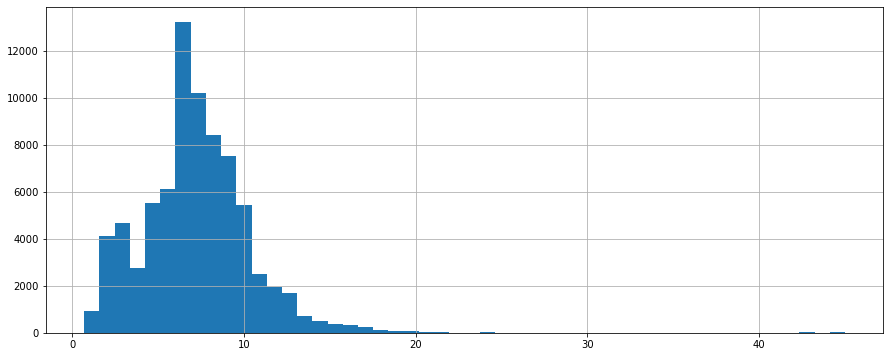

In [17]:
df_score['sub_sum'].hist(figsize=(15,6), bins=50, rwidth=1);

We can assign the following ranges:

| Range                  | Cluster     |
|:----------------------- |-------------|
|sub_sum > 20                |Urgent/Outlier|
|10 > sub_sum > 20       |Very High|
|5 > sub_sum > 20      |High|
|sub_sum < 5                 |Normal|



In [18]:
# Creating 'cluster' column
df_score['cluster'] = ['Urgent/Outlier' if x>20 else 'Very High' if 10<=x<20 else 'High' if 5<=x<10 else 'Normal' for x in df_score['sub_sum']]
df_score[['accountid','semana_ref', 'sub_sum', 'cluster']].sort_values(by='semana_ref').head()

,accountid,semana_ref,sub_sum,cluster
50102,0011L00002Y3A9iQAF,2020-08,1.0,Normal
22914,0011L00002daFdCQAU,2020-08,3.1,Normal
22915,0011L00002daFdCQAU,2020-08,5.5,High
23331,0011L00002Y3ahGQAR,2020-08,6.0,High
53425,0011L00002bEU0RQAW,2020-08,0.8,Normal


In [19]:
# Qty of calls per cluster
df_score['cluster'].value_counts().sort_values(ascending=False)

High              49037
Normal            16859
Very High         11434
Urgent/Outlier      159
Name: cluster, dtype: int64

#### 4. <b>Using the tables provided, make a query that returns the volume of calls per week for the last three months for each customer cluster proposed in question 3.

In [20]:
sql_query = pandasql.sqldf( 
    """
      SELECT semana_ref as Week, cluster as Cluster, count(accountid) as Cases  
      FROM df_score 
      WHERE semana_ref >= '2020-32' 
      GROUP BY Week, Cluster
      ORDER BY Week ASC, Cases DESC;
    """
, globals())

sql_query

,Week,Cluster,Cases
0,2020-32,High,2047
1,2020-32,Normal,664
2,2020-32,Very High,569
3,2020-32,Urgent/Outlier,14
4,2020-33,High,2128
5,2020-33,Normal,616
6,2020-33,Very High,478
7,2020-33,Urgent/Outlier,7
8,2020-34,High,2249
9,2020-34,Normal,731


5. <b>To improve the direction of the Customer Relations area, the management
needs the necessary input to understand how our customers behave and
thus improve decision making. Present at least 3 KPI's that you judge
relevant for daily monitoring of the RC operation.

KPI creation opportunities are diverse and vary according to the stakeholders that will consume them. Below are some of them:

**KPI's using only the provided dataframes:**

- **Proportion of calls per subject per week**<br>
To understand the areas where there are more operational or UX-related bottlenecks, as well as the trend of these bottlenecks.
- **Proportion of positive/negative ratings by subject**<br>
To identify which issues are contributing to promoters and detractors and transfer issues that generate promoters to the Marketing department (understanding of generating value for campaigns) and issues that generate detractors to the operations/continuous improvement department.
- **Median waitingtime per week**<br>
To identify the trend in service efficiency.
- **Amount of accreditations per city per day**<br>
To identify the trend in Marketing/Sales efficiency.
- **Proportion of # calls with issues related to product acquisition / related to uninstallation**<br>
For setting more general growth targets.

**General KPI's:**

- **LTV** (Lifetime Value)<br>
To estimate the lifecycle net profit of each customer.<br>Formula: *Average sales ticket X number of customer purchases over time*
- **CAC** (Customer Acquisition Cost)<br>
To measure financial health and marketing efficiency.<br>Formula: *Sum of investments made in Marketing & Sales / # Customers acquired in the same period*
- **NPS** (Net Promoter Score)<br>
To measure customer satisfaction, in a simplified way.<br>Formula: *% of promoters – % of detractors*